In [1]:
import numpy as np
import pandas as pd
from Modules import read_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import Modules.plot_ax_violin as violin
from sklearn.neighbors.kde import KernelDensity

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def get_separator_genes():
    fname = 'Differential/edgeR/General/Sst-OLM vs Pvalb.txt'
    df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    genes = [df.loc[df.logFC>1,:].head(n=10).index.tolist(), df.loc[df.logFC<-1,:].head(n=10).index.tolist()]
    
    return genes

def get_target_genes():
    genes = [['Slc17a7', 'Slc17a6', 'Neurod6', 'Gad1', 'Sst', 'Pvalb']] + get_separator_genes()
    
    return genes

def get_colors():
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    colors = df_marker.loc[['Pvalb', 'SST-OLM'], 'Face'].values
    
    return colors

def read_lin_data():
    df_lin = read_data.read_labeled_tpm_data('Lab_Pvalb', tpm_args={'age_cutoff':20})
    
    return df_lin

def read_olm_data():
    df_olm = read_data.read_labeled_tpm_data('Lab_OLM')
    
    df_olm = df_olm.xs('SST-OLM', level='CellType', axis=1).copy()
    
    arrays = [df_olm.columns, ['OLM']*df_olm.shape[1]]
    names = ('Cell', 'CellType')
    
    df_olm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_olm

def read_in_data():
    df_lin = read_lin_data()
    df_olm = read_olm_data()
    
    df_lab = pd.concat((df_lin, df_olm), axis=1)
    
    return df_lab

def do_heat_map(df, genes, fig, celltypes=['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC', 'OLM']):
    celltypes = celltypes
    genelist = sorted({gene for gene_set in genes for gene in gene_set})
    
    df = np.log2(1+df.loc[genelist, df.columns.get_level_values('CellType').isin(celltypes)])
    Highest = df.values.max()
    
    Top = .88
    H = .014
    Width = (.8/6) - .01
    
    for row, gene_set in enumerate(genes):
        Height = H * len(gene_set)
        Bottom = Top - Height
        
        for col, celltype in enumerate(celltypes):
            Left = .2 + (Width+.01)*col
            ax = fig.add_axes([Left, Bottom, Width, Height])
            ax.set_xticks([])
            datalist = df.loc[gene_set, df.columns.get_level_values('CellType')==celltype]
            pcol = ax.pcolor(datalist, vmin=0, vmax=Highest, cmap=mpl.cm.Reds)
            
            if col == 0:
                ax.set_yticks(np.arange(datalist.shape[0])+.5)
                ax.set_yticklabels(gene_set, fontsize=7)
            else:
                ax.set_yticks([])
            ax.axis([0,datalist.shape[1],0,datalist.shape[0]])
            
            if row == 0:
                ax.set_title(celltype, fontsize=10)
        Top = Bottom - .01
    
    return Top

def get_kde(data):
    step = data.std()/2 + .001
    if data.min() == data.max():
        data = np.random.rand(data.size)*.01 + data.min()
    xvals = np.linspace(0, 1.2, 60)
    kde = KernelDensity(kernel='gaussian', bandwidth=step).fit(data[:,np.newaxis])
    log_dens = np.exp(kde.score_samples(xvals[:,np.newaxis]))
    log_data = np.exp(kde.score_samples(data[:,np.newaxis]))
    
    return xvals, log_dens, log_data

def break_up_kde(xvals, log_dens, cutoff=.01):
    to_plot = log_dens>=cutoff
    
    if to_plot.sum() == to_plot.size:
        return [xvals], [log_dens]
    elif to_plot.sum() == 0:
        return [], []
    
    inds = np.arange(to_plot.size,dtype=int)[to_plot]
    
    sub_inds = np.split(inds, np.arange(inds.size-1,dtype=int)[np.diff(inds)>1]+1)
    sub_inds = [sub_ind if sub_ind.size>1 else [sub_ind[0],sub_ind[0]] for sub_ind in sub_inds]
    
    xvals = [xvals[sub_ind] for sub_ind in sub_inds]
    log_dens = [log_dens[sub_ind] for sub_ind in sub_inds]
    
    return xvals, log_dens

def get_normalized_kde(data, high=4, width=.4):
    xvals, log_dens, log_data = get_kde(data)
    peak = max(high, log_dens.max())
    log_dens = log_dens / peak * width
    log_data = log_data / peak * width
    
    xvals, log_dens = break_up_kde(xvals, log_dens, cutoff=.01)
    
    return xvals, log_dens

def plot_gene_violin(data, ax, celltypes, colors):
    high = data.max()
    if high == 0:
        return
    data = data / high
    
    data1 = data.loc[data.index.get_level_values('CellType').isin(celltypes[0])]
    data2 = data.loc[data.index.get_level_values('CellType').isin(celltypes[1])]
    yvals1, log_dens1 = get_normalized_kde(data1, high=4, width=.4)
    yvals2, log_dens2 = get_normalized_kde(data2, high=4, width=.4)
    
    kwargs = {'edgecolor':'#000000', 'linewidth':.5, 'zorder':0}
    for yvals, log_dens in zip(yvals1, log_dens1):
        ax.fill_betweenx(yvals, -.5+log_dens, -.5-log_dens, facecolor=colors[0], **kwargs)
    for yvals, log_dens in zip(yvals2, log_dens2):
        ax.fill_betweenx(yvals, .5+log_dens, .5-log_dens, facecolor=colors[1], **kwargs)
        
    #ax.plot([0,1.5], [0,0], linewidth=.1, color='black')
    
    return

def do_split_violin_plots(df, genes, fig, top, colors):
    celltypes = [('vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'), ('OLM',)]
    cells = [cell for celltype in celltypes for cell in celltype]
    genelist = [gene for gene_set in genes for gene in gene_set]
    df = np.log2(1+df.loc[genelist,df.columns.get_level_values('CellType').isin(cells)])
    
    Width = .05
    Height = .03
    Left = .2
    Bottom = top - Height
    
    for row, gene_set in enumerate(genes):
        for col, gene in enumerate(gene_set):
            ax = fig.add_axes([Left+Width*col, Bottom-.1*row, Width, Height])
            ax.axis([-1,1,-.02,1.3])
            ax.set_yticks([])
            ax.set_xticks([.75])
            ax.set_xticklabels([gene], rotation=90, ha='center', fontsize=6)
            ax.tick_params(size=0)
            
            plot_gene_violin(df.loc[gene], ax, celltypes, colors)
    
    return

def do_plots(df, genes, colors):
    fig = plt.figure(figsize=(8.5,11))
    top = do_heat_map(df, [genes[0]], fig)
    do_split_violin_plots(df, genes[1:], fig, top, colors)

    return fig

In [3]:
df = read_in_data()
colors = get_colors()
genes = get_target_genes()

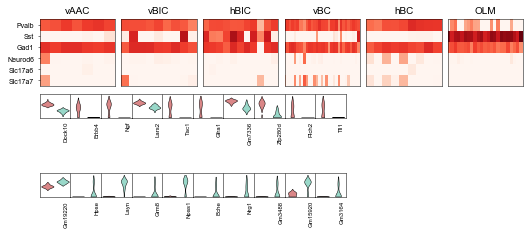

In [4]:
fig = do_plots(df, genes, colors)
fig.savefig('quick.pdf')
plt.show()